<h1> Captsone Project - The Battle Of Neighbourhoods - Live in Montreal </h1>

<h2> Introduction/Business Problem </h2>

Montreal, the 2nd most populated city in Canada has more than 4 millions population with a slow growth of 0.73% average every year. Montreal is also known as the 2nd largest economy in Canada by having a variety of businesses implementing themselves out there. As the nest of opportunities, many big tech companies started considering the city to have new offices - Google, Facebook, Microsoft to name a few. 

In the case where an individual had to relocate for a job opportunity, what would be the best locations we could suggest him? The purpose of this report is to identify what would be the best options thru a data driven research. We will identify amneties and venues based on their ratings from which we will offer options based on the relocator preferences.

This project targets mostly individuals that are not familiar with the city and that are searching a convenient borough where they can live. It will bring also options that fit the individual interest. As an example, an individual in the need of relocating, who likes parks, we expect him willing to be close to that type of venue.

<h2> Data Description </h2>

Data :<br>

- Montreal city boroughs names with their coordinates (latitude and longitude).
    - Data pulled from Wikipedia with the BeautifulSoup library. Alternatively, we could manually put the data in a CSV file.
    - Will be used with Foursquare API data to define the best venues of each boroughs.
    - We will use Folium to vizualize the different boroughs within Montreal.

- Top 10 venues based on ratings, which include their type(e.g : Restaurants, Bars, Malls, Parks, etc.) and their location (latitude and logitude).
    - For each 19 neighborhoods of Montreal. 
    - Clustering process with K-Mean algorithm to define more precisely where good venues and amneties are.
    - Data will be vizualized on folium generated map.
    - Will use the panda library to analyze and organize the data.

How : 

Several platform and techniques will be used during this report.
- Python as the interpreter language. As R, extensively used in Data analytic field. Useful for the diversity of libraries.
- Geocoders to convert address into coordinates value.
- Pandas for dataframe manipulation.
- Folium for map vizualization with our point of interest(Neighbordhoods and venues).
- Foursquare offers an API giving access to a wide range of data related to locations.
- As a clustering algorithm, K-Mean will be used to define ideal locations.


In [1]:
%pip install -q geocoder geopy folium bs4 pandas lxml html5lib sklearn matplotlib OSMPythonTools
from bs4 import BeautifulSoup
import pandas as pd
from geopy.geocoders import Nominatim
import geocoder
import numpy as np
import json
from re import search
import re
import requests
import matplotlib.pyplot as plt
import unidecode
import branca.colormap as cm
from io import StringIO
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from folium import plugins
from folium.plugins import HeatMap

Note: you may need to restart the kernel to use updated packages.


In [2]:
with open('Credentials.json') as f:
    data = json.load(f)
    MyGoogleAPIKey = data['MyGoogleAPIKey']
    CLIENT_ID = data['CLIENT_ID']
    CLIENT_SECRET = data['CLIENT_SECRET']
VERSION = '20180605'
radius = 250
LIMIT = 100

In [3]:
def get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location']
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]

In [4]:
#File built from boroughs list in Wikipedia
#Lat Long obtained from Function above
dfMtlPos = pd.read_csv('MontrealBoroughsLatLong.csv')
dfMtlVenues = pd.read_csv("MontrealVenus.csv")

#dfMtlPos

In [44]:
dfMtlVenues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Pierrefonds-Roxboro,45.509630,-73.819152,4bdb01a53904a593993d489e,Restaurant Bombay Choupati,45.508404,-73.820454,Indian Restaurant
1,Pierrefonds-Roxboro,45.509630,-73.819152,4e4eeb2b1495fc2ca3f806fc,Aryana,45.504587,-73.817885,Middle Eastern Restaurant
2,Pierrefonds-Roxboro,45.509630,-73.819152,51313bfee4b098c263c5d332,Les 3 Maria,45.504460,-73.817805,Portuguese Restaurant
3,Pierrefonds-Roxboro,45.509630,-73.819152,4c49c15c3013a59398152de3,Shahi Palace,45.503766,-73.816520,Indian Restaurant
4,Pierrefonds-Roxboro,45.509630,-73.819152,51411f87e4b091a07e3025ce,Chateau Kebab,45.502341,-73.815488,Middle Eastern Restaurant
...,...,...,...,...,...,...,...,...
2073,Sainte-Anne-de-Bellevue,45.403276,-73.950361,4f0cd732e4b04a8cd715a351,Le Balnéo Bistro Francais,45.387028,-73.962467,French Restaurant
2074,Sainte-Anne-de-Bellevue,45.403276,-73.950361,4c670f928e9120a1e7cbd964,PJC Jean Coutu,45.389711,-73.963013,Pharmacy
2075,Sainte-Anne-de-Bellevue,45.403276,-73.950361,4beef97b40812d7f94d09c1a,Metro Plus Ile-Perrot,45.382755,-73.954656,Supermarket
2076,Sainte-Anne-de-Bellevue,45.403276,-73.950361,4ba50beff964a52045d538e3,Mama Bravo,45.387820,-73.965852,Italian Restaurant


In [50]:
dfMtlVenuesCount = dfMtlVenues.groupby(['Venue Category','Neighborhood']).size()

#dfMtlVenuesCount.reset_index(inplace=True)
dfMtlVenuesCount.columns = ['Venue Category	','Neighborhood', 'Count']
dfMtlVenuesCount.sort_values( ascending=False)
#dfMtlVenuesCount.to_csv('MontrealVenuesCount.csv')

In [5]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [6]:
loc = 'Montreal Boroughs'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)
map = folium.Map(location=[45.5017, -73.5673], zoom_start=11)
def style_function(feature):
    return { 'color': 'darkblue', 'fillOpacity': 0.5, }

map.get_root().html.add_child(folium.Element(title_html))
plugins.ScrollZoomToggler().add_to(map)
folium.GeoJson("MontrealGeoShape.geojson", style_function=style_function, name='geojson').add_to(map)

#Add boroughs 
for borough,Type,lat,long in zip(dfMtlPos['Boroughs'],dfMtlPos['Type'],dfMtlPos['Lat'],dfMtlPos['Long']):
    label = folium.Popup(borough, parse_html=True)
    color='yellow'
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)

#Add venues to map        
for borough,lat,long in zip(dfMtlVenues['Venue'],dfMtlVenues['Venue Latitude'],dfMtlVenues['Venue Longitude']):
    label = folium.Popup(borough, parse_html=True)
    color='red'
    folium.CircleMarker(
        [lat, long],
        radius=1,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
map

In [7]:
#Have venues records and venues categories transposed then grouped by Neighborhood 
dfMtlVenuesTranspose = pd.get_dummies(dfMtlVenues[['Venue Category']], prefix="", prefix_sep="")
dfMtlVenuesTranspose['Neighborhood'] = dfMtlVenues['Neighborhood']
dfMtlVenuesTranspose = dfMtlVenuesTranspose[([dfMtlVenuesTranspose.columns[-1]] + list(dfMtlVenuesTranspose.columns[:-1]))]
dfMtlGroupedVenues = dfMtlVenuesTranspose.groupby('Neighborhood').mean().reset_index()

In [9]:
num_top_venues = 5
indicators = ['st', 'nd', 'rd']
def fTopVenues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dfMtlGroupedVenues['Neighborhood']

for ind in np.arange(dfMtlGroupedVenues.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = fTopVenues(dfMtlGroupedVenues.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ahuntsic-Cartierville,Café,Pharmacy,Liquor Store,Breakfast Spot,Park
1,Anjou,Coffee Shop,Pharmacy,Liquor Store,Breakfast Spot,Grocery Store
2,Baie-d'Urfe,Pub,Train Station,Zoo,Sporting Goods Shop,Hotel
3,Beaconsfield,Italian Restaurant,Restaurant,Pharmacy,Gas Station,Coffee Shop
4,Cote Saint-Luc,Coffee Shop,Bowling Alley,Automotive Shop,Gym,Clothing Store
5,Cote-des-Neiges-Notre-Dame-de-Grace,Park,Coffee Shop,Café,Gym,Indian Restaurant
6,Dorval,Coffee Shop,Hotel,Airport Lounge,Airport Service,Italian Restaurant
7,Kirkland,Coffee Shop,Italian Restaurant,Liquor Store,Furniture / Home Store,Bank
8,L'ile-Bizard-Sainte-Genevieve,Golf Course,Restaurant,Park,Grocery Store,Convenience Store
9,LaSalle,Fast Food Restaurant,Coffee Shop,Pizza Place,Breakfast Spot,Supermarket


In [10]:
dfMtlCrime = pd.read_csv("MontrealCriminality.csv", encoding="ISO-8859-1")
dfMtlCrime['DATE'] = pd.to_datetime(dfMtlCrime['DATE'])
dfMtlCrime.sort_values('DATE',inplace=True,ascending=False)
dfMtlCrime = dfMtlCrime[(dfMtlCrime['DATE'] > '2020-06-30') & (dfMtlCrime['DATE'] < '2020-12-31')]
dfMtlCrime.rename(columns={'LONGITUDE':'long','LATITUDE':'lat'}, inplace=True)
dfMtlCrime.drop(['QUART', 'PDQ','X','Y','DATE'], axis=1, inplace=True)
dfMtlCrime = dfMtlCrime[dfMtlCrime.long != 1]
dfMtlCrime=dfMtlCrime.tail(1000)

In [11]:
# def fGeoToAddr(lat,long):
#     geolocator = Nominatim(user_agent="https")
#     return geolocator.reverse(str(lat)+","+str(long))
# dfMtlCrime['Address'] = ""
# dfMtlCrime.reset_index(inplace=True,drop=True)
# dfMtlCrime.shape
# dfMtlCrime['Neighborhood'] = ""
# for index,row in enumerate(dfMtlCrime.iterrows()):
#   dfMtlCrime.at[index,"Address"] = fGeoToAddr(row[1][2],row[1][1])

In [12]:
#dfMtlCrime.to_csv('MontrealCrimesPerNeighboord.csv')
dfMtlCrime = pd.read_csv("MontrealCrimesPerNeighboord.csv", encoding="utf-8")

In [13]:
r = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H")
soup = BeautifulSoup(r.content)
dictPostalCode = {} 
for link in soup.find_all('td'):
    if link.find('a') != None and link.find('b') != None :
        dictPostalCode[link.find('b').text] = link.find('a').text

In [14]:
for index,row in enumerate(dfMtlCrime.iterrows()):
    for record in str(dfMtlCrime['Address'][index]).split(','):
        if re.match(r'^H[0-9](?i)[a-z]\s?[0-9](?i)[a-z][0-9]$', record.strip()):
            if len(record.strip().split(" ")) == 1:
                dfMtlCrime['Neighborhood'][index] = dictPostalCode[record.strip()[0:3]]
            else:
                dfMtlCrime['Neighborhood'][index] = dictPostalCode[record.strip().split(" ")[0]]
        elif re.match(r'^H[0-9](?i)[a-z]$', record.strip()):
            dfMtlCrime['Neighborhood'][index] = dictPostalCode[record.strip()[0:3]]
        elif re.match(r'^(?i)[a-z][0-9](?i)[a-z]\s?[0-9](?i)[a-z][0-9]$', record.strip()):
            dfMtlCrime.drop([dfMtlCrime.index[index]], inplace=True)
dfMtlCrime.reset_index(drop=True, inplace=True)

ipykernel_launcher:3: DeprecationWarning: Flags not at the start of the expression '^H[0-9](?i)[a-z]\\s?[' (truncated)
ipykernel_launcher:8: DeprecationWarning: Flags not at the start of the expression '^H[0-9](?i)[a-z]$'
ipykernel_launcher:10: DeprecationWarning: Flags not at the start of the expression '^(?i)[a-z][0-9](?i)[' (truncated)


In [15]:
dfDummyCrime = pd.get_dummies(dfMtlCrime[['CATEGORIE']], prefix="", prefix_sep="")
dfDummyCrime['Neighborhood'] = dfMtlCrime['Neighborhood']
dfDummyCrime = dfDummyCrime[([dfDummyCrime.columns[-1]] + list(dfDummyCrime.columns[:-1]))]
dfDummyCrime = dfDummyCrime.groupby(['Neighborhood']).sum()
dfDummyCrime["Total"] = dfDummyCrime["Introduction"] + dfDummyCrime["Méfait"] + dfDummyCrime["Vol dans / sur véhicule à moteur"] + dfDummyCrime["Vol de véhicule à moteur"] + dfDummyCrime["Vols qualifiés"]
dfDummyCrime.sort_values(ascending=False, by=['Total'], inplace=True)
dfDummyCrime.rename({"Introduction":"Break in","Méfait":'Mischief',"Vol dans / sur véhicule à moteur":'Robbery involving vehicule',"Vol de véhicule à moteur":'Robbery of Vehicule',"Vols qualifiés":'Armed Robbery'}, inplace=True,axis='columns',errors="raise")
dfDummyCrime.reset_index(inplace=True, drop=False)
#print(dfDummyCrime.head(5))

Text(0.5, 0, 'Neighborhoods')

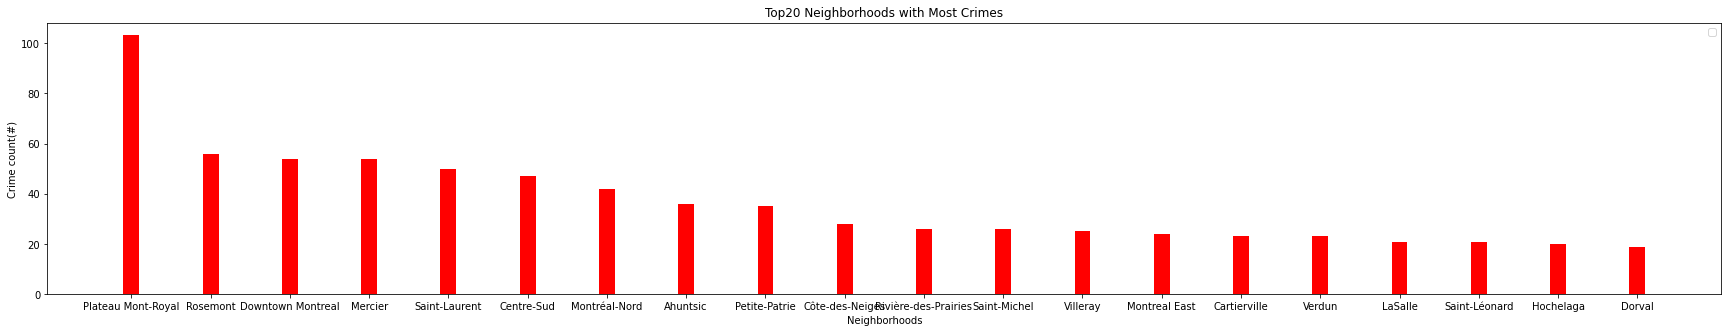

In [16]:
#fig, ax = plt.subplots()
#width = np.diff(dates).min()
#ax.xaxis_date()
#fig.autofmt_xdate()
#dfMisChief = dfDummyCrime.sort_values(ascending=False, by=['Mischief'])
plt.figure(figsize=(30, 5))
plt.title("Top20 Neighborhoods with Most Crimes")
plt.legend(labels = ['Total'])
# This is the location for the annotated text
#i = 1.0
#j = 2000
#for i in range(len(dfDummyCrime['Neighborhood'].head(20))):
#    plt.annotate(dfDummyCrime['Total'][i], (-0.1 + i, dfDummyCrime['Total'] + j))
plt.bar(dfDummyCrime['Neighborhood'].head(20),dfDummyCrime['Total'].head(20),color="red",align='center',width=0.2)
plt.ylabel('Crime count(#)')
plt.xlabel('Neighborhoods')

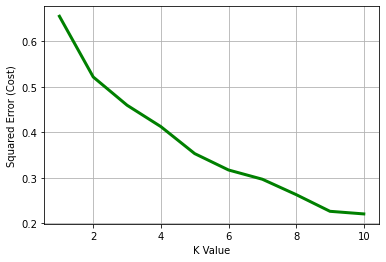

In [22]:
cost = []
dfMtlGroupedCluster = dfMtlGroupedVenues.drop('Neighborhood', 1)
for i in range(1,11):
    KM = KMeans(n_clusters= i, max_iter= 2800)
    KM.fit(dfMtlGroupedCluster)
    cost.append(KM.inertia_)
plt.plot(range(1,11), cost, color='g' , linewidth='3')
plt.xlabel("K Value")
plt.ylabel("Squared Error (Cost)")
plt.grid()
plt.show()


In [42]:
def show_choropleth_map(geo_data, dataframe, columns, legend_name, cinemas=None, malls=None):
    bins = list(dataframe[columns[1]].quantile([0, 0.25, 0.5, 0.75, 1]))
    center = xy_to_lonlat((mtl_max_x+mtl_min_x)/2, (mtl_max_y+mtl_min_y)/2)
    map = folium.Map(location=(center[1], center[0]), zoom_start=11)
    folium.TileLayer('cartodbpositron').add_to(map)
    folium.Choropleth(
        geo_data=geo_data,
        data=dataframe,
        columns=columns,
        key_on='feature.properties.district',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        bins=bins,
        legend_name=legend_name
    ).add_to(map)

    if dfMtlVenues is not None:
        for lat, lon in dfMtlVenues:
            folium.CircleMarker([lat, lon], radius=3, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map)
    if cinemas is not None:
        for lat, lon in cinemas:
            folium.CircleMarker([lat, lon], radius=3, color='yellow', weight=1, fill=True, fill_color='red', fill_opacity=1).add_to(map)

    return map


In [ ]:
show_choropleth_map(geo_data="MontrealGeoShape.geojson",
                    dataframe=census_df.reset_index(),
                    columns=['index', 'Population'],
                    legend_name='Population',
                    cinemas=[(c[2], c[3]) for c in montreal_cinemas.values()],
                    malls=[(c[2], c[3]) for c in montreal_shopping_malls.values()])